In [1]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [2]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall
import PyPlot; const plt = PyPlot ;

In [3]:
training_data = CSV.read("training_data.csv",DataFrame)
num_rows = nrow(training_data)
rename!(training_data,:sat_temperatures_K=>:sat_temp_strings, :sat_pressures_MPa=>:sat_pressure_strings,
        :sat_volumes_liq_m3_per_mol=>:sat_vol_liq_strings,:sat_volumes_vap_m3_per_mol=>:sat_vol_vap_strings)

# Define the column names
array_cols_to_create = [:sat_temperatures_K, :sat_pressures_MPa, :sat_volumes_liq_m3_per_mol, :sat_volumes_vap_m3_per_mol]
string_columns = [:sat_temp_strings, :sat_pressure_strings, :sat_vol_liq_strings, :sat_vol_vap_strings]

# Initialize the columns with zeros
for col in array_cols_to_create
    training_data[!, col] .= fill([0.0], num_rows)
end

# Process and assign the values to the DataFrame
for (col, str_col) in zip(array_cols_to_create, string_columns)
    for i = 1:num_rows
        string_sq_brackets_removed = replace(training_data[i, str_col], r"[][]" => "")
        vector_of_floats = [parse(Float64, val) for val in split(string_sq_brackets_removed, ",")]
        training_data[i, col] = vector_of_floats
    end
end

# Remove the string columns
select!(training_data, Not(string_columns...)) ;

# training_data

In [10]:
training_data ;

In [4]:
# Check number of functional groups in dataset & number of species per fucntional group
unique_values = unique(training_data[!, :family])
num_unique_values = length(unique_values)

dataset_summary = DataFrame(
    functional_group = unique_values,
    occurances = fill(0,num_unique_values)
)

for i = 1:length(unique_values)
     count_occurrences = count(x -> x == unique_values[i], training_data.family)
     dataset_summary[i,:occurances] = count_occurrences ;
end

dataset_summary

Row,functional_group,occurances
,String31,Int64
1,Alkanes,80
2,Inorganic compounds,44
3,Other compounds,622
4,Alkynes,12
5,Nitriles,22
6,Elements,9
7,Alkenes,66
8,Aldehydes,22
9,Amines,77


In [11]:
filtered_data_chem_family = filter(row -> occursin("[2H]", row.isomeric_SMILES), training_data) ;
filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 

species_names = filtered_data_chem_family.species ;
filtered_data_chem_family 

Row,species,CAS,isomeric_SMILES,family,Mw,interaction,source,critical_temperature_K,critical_pressure_MPa,critical_volume_m3_per_mol,p_sat_AAD,p_sat_AAD_outliers,rho_liq_AAD,rho_liq_sat_AAD,rho_liq_sp_AAD,rho_vap_AAD_outliers,p_sat_n_points,p_sat_n_points_outliers,rho_liq_n_points,rho_liq_sat_n_points,rho_liq_sp_n_points,rho_vap_n_points_outliers,sat_temperatures_K,sat_pressures_MPa,sat_volumes_liq_m3_per_mol,sat_volumes_vap_m3_per_mol
,String,String15,String,String31,Float64,String15,String31,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Array…,Array…,Array…,Array…
1,ammonia-d3,13550-49-7,[2H]N([2H])[2H],Other compounds,17.027,ASSOCIATIVE,10.1021/acs.iecr.3c02255,419.98,1.47831e7,6.85203e-5,0.27,0.31,0.09,0.13,0.04,-1.0,231,232,20,12,8,-1,"[209.99, 214.276, 218.561, 222.847, 227.132, 231.418, 235.703, 239.989, 244.274, 248.56 … 381.411, 385.696, 389.982, 394.267, 398.553, 402.838, 407.124, 411.409, 415.695, 419.98]","[14942.5, 19991.9, 26409.8, 34475.0, 44503.4, 56849.4, 71907.6, 90114.1, 1.11947e5, 1.37927e5 … 7.57252e6, 8.21244e6, 8.89012e6, 9.60668e6, 1.03632e7, 1.11609e7, 1.20007e7, 1.28836e7, 1.38108e7, 1.47831e7]","[1.9988e-5, 2.01268e-5, 2.02686e-5, 2.04134e-5, 2.05617e-5, 2.07136e-5, 2.08695e-5, 2.10295e-5, 2.11941e-5, 2.13635e-5 … 3.3529e-5, 3.45992e-5, 3.58151e-5, 3.72166e-5, 3.88631e-5, 4.08486e-5, 4.33363e-5, 4.66566e-5, 5.16988e-5, 6.85203e-5]","[0.11499, 0.0874613, 0.067326, 0.0524103, 0.0412286, 0.0327517, 0.0262573, 0.0212324, 0.0173079, 0.0142159 … 0.000252275, 0.000227561, 0.000204973, 0.000184216, 0.000165012, 0.000147073, 0.000130065, 0.000113509, 9.63851e-5, 6.85203e-5]"
2,ethylene-d4,683-73-8,[2H]C([2H])=C([2H])[2H],Other compounds,28.031,NONPOLAR,10.1021/acs.iecr.3c02255,288.155,6.13393e6,0.000122974,0.54,-1.0,0.24,0.24,-1.0,-1.0,43,-1,35,35,-1,-1,"[144.078, 147.018, 149.958, 152.899, 155.839, 158.779, 161.72, 164.66, 167.6, 170.541 … 261.692, 264.632, 267.573, 270.513, 273.453, 276.394, 279.334, 282.274, 285.215, 288.155]","[17260.5, 22066.8, 27909.1, 34943.6, 43338.7, 53275.0, 64944.4, 78550.2, 94306.4, 1.12437e5 … 3.39049e6, 3.64054e6, 3.90349e6, 4.17973e6, 4.46961e6, 4.77347e6, 5.09163e6, 5.42434e6, 5.77177e6, 6.13393e6]","[4.05381e-5, 4.07926e-5, 4.1051e-5, 4.13137e-5, 4.15808e-5, 4.18528e-5, 4.21299e-5, 4.24125e-5, 4.27011e-5, 4.2996e-5 … 6.18768e-5, 6.35236e-5, 6.54128e-5, 6.76175e-5, 7.02474e-5, 7.34785e-5, 7.76198e-5, 8.32984e-5, 9.21958e-5, 0.000122974]","[0.0689485, 0.0549543, 0.0442478, 0.0359667, 0.0294955, 0.0243897, 0.0203243, 0.0170596, 0.0144166, 0.0122605 … 0.000423151, 0.000386119, 0.000351611, 0.00031927, 0.000288736, 0.000259609, 0.00023138, 0.000203246, 0.000173373, 0.000122974]"
3,o-deuteromethanol,1455-13-6,[2H]OC,Other compounds,32.026,ASSOCIATIVE,10.1021/acs.iecr.3c02255,541.686,1.18097e7,0.00012178,1.25,-1.0,0.29,0.29,-1.0,-1.0,126,-1,22,22,-1,-1,"[270.843, 276.371, 281.898, 287.425, 292.953, 298.48, 304.008, 309.535, 315.062, 320.59 … 491.94, 497.467, 502.994, 508.522, 514.049, 519.577, 525.104, 530.632, 536.159, 541.686]","[3029.58, 4340.5, 6119.84, 8499.79, 11639.6, 15728.6, 20989.6, 27681.5, 36102.4, 46592.3 … 5.46781e6, 6.00398e6, 6.57835e6, 7.19258e6, 7.84834e6, 8.54731e6, 9.29121e6, 1.00817e7, 1.09207e7, 1.18097e7]","[3.82442e-5, 3.84795e-5, 3.87189e-5, 3.89626e-5, 3.92112e-5, 3.94651e-5, 3.97246e-5, 3.99904e-5, 4.02628e-5, 4.05425e-5 … 6.02419e-5, 6.19983e-5, 6.40037e-5, 6.63291e-5, 6.90802e-5, 7.24256e-5, 7.66603e-5, 8.23847e-5, 9.12254e-5, 0.00012178]","[0.738877, 0.525589, 0.379686, 0.27828, 0.20674, 0.155556, 0.11845, 0.0912132, 0.0709838, 0.0557918 … 0.000501204, 0.000447132, 0.000398372, 0.000354167, 0.00031382, 0.000276654, 0.000241931, 0.000208672, 0.000174917, 0.00012178]"
4,deuterium sulfide,13536-94-2,[2H]S[2H],Other compounds,33.988,NONPOLAR,10.1021/acs.iecr.3c02255,378.725,1.0071e7,9.81749e-5,0.29,-1.0,0.21,0.17,0.27,-1.0,59,-1,38,22,16,-1,"[189.362, 193.227, 197.091, 200.956, 204.821, 208.685, 

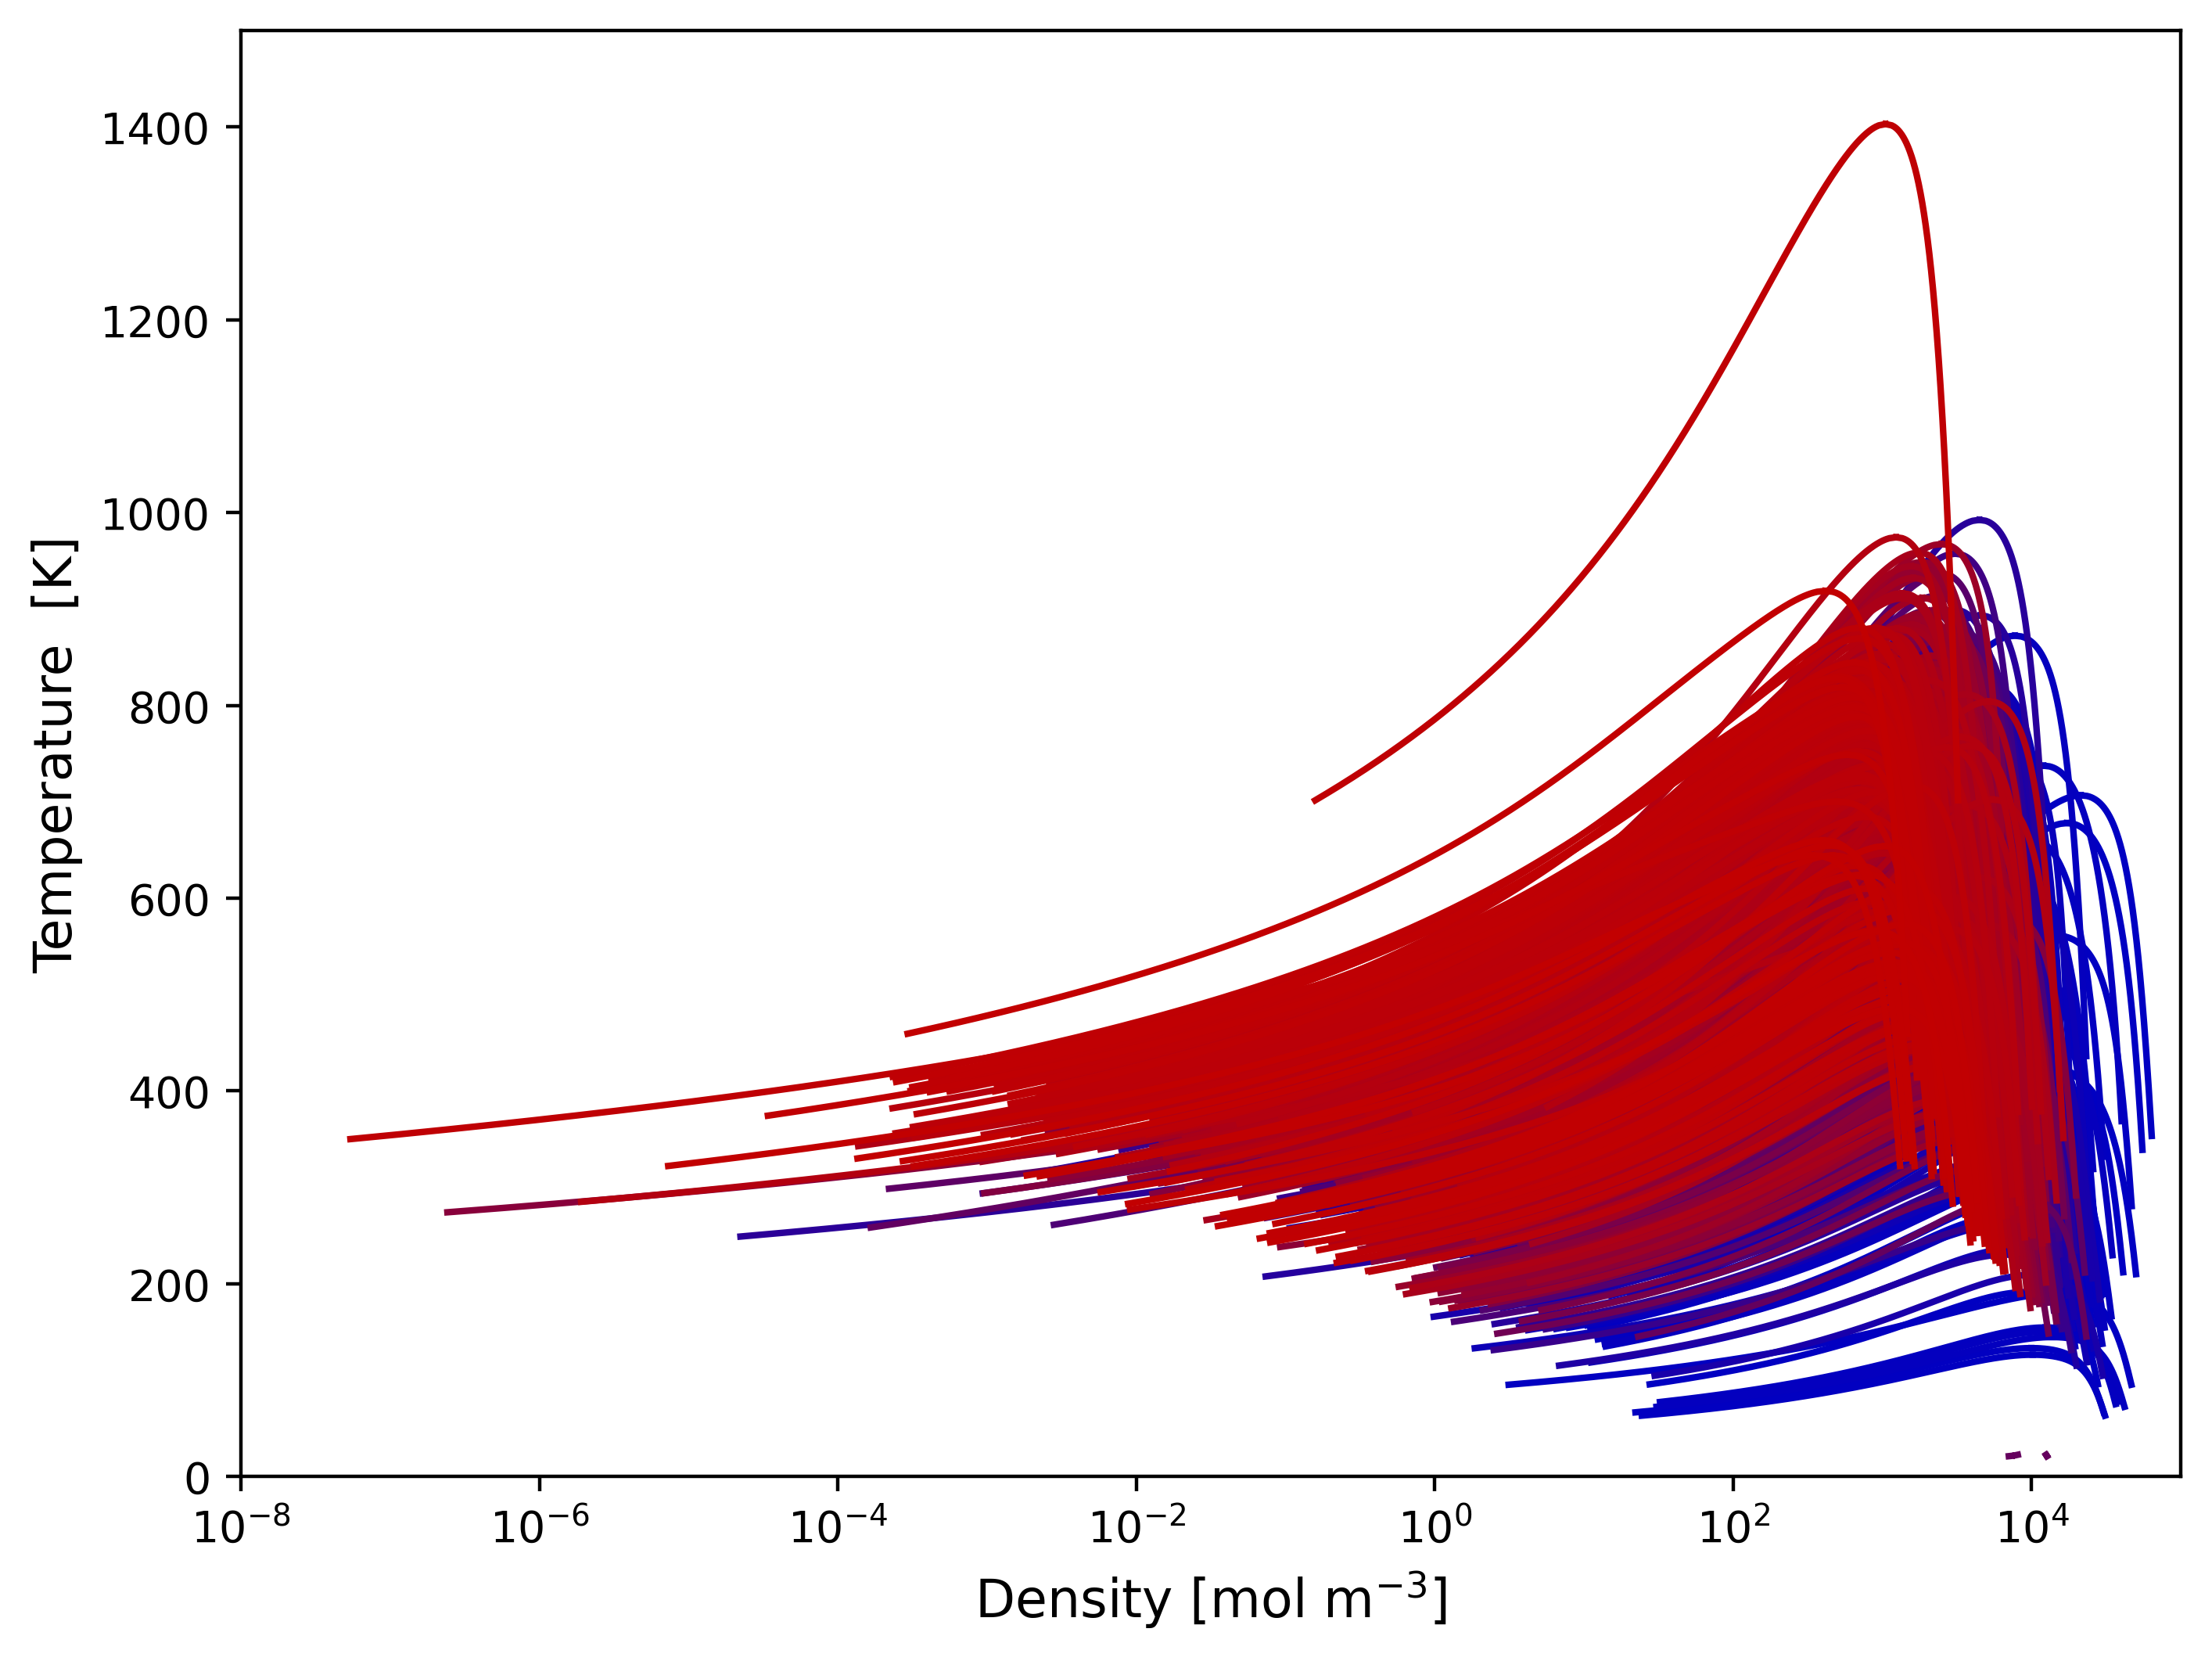

In [6]:
nrows_data = nrow(training_data)

# All phase envelopes plot
colour_grad_1 = collect(range(1,194,nrows_data) ./255) 
colour_grad_2 = collect(range(194,1,nrows_data) ./255)

plt.figure(figsize=(8, 6), dpi=400)

for i = 1:nrows_data

plt.semilogx(1 ./training_data[i,:sat_volumes_liq_m3_per_mol],training_data[i,:sat_temperatures_K], color = [colour_grad_1[i] 0 colour_grad_2[i]])
plt.semilogx(1 ./training_data[i,:sat_volumes_vap_m3_per_mol],training_data[i,:sat_temperatures_K],color = [colour_grad_1[i] 0 colour_grad_2[i]])

end

# plt.legend(loc="lower right",bbox_to_anchor =(-0.1,-0.05),frameon=false,fontsize=8,ncol=3) 
plt.xlabel("Density [mol m\$^{-3}\$]",fontsize=12)
plt.ylabel("Temperature  [K]",fontsize=12)
plt.ylim([0,1500])
plt.xlim([10^-8,10^5])

# plt.savefig("all_compound_phase_envelopes.png",dpi=400)

In [7]:
training_data ;

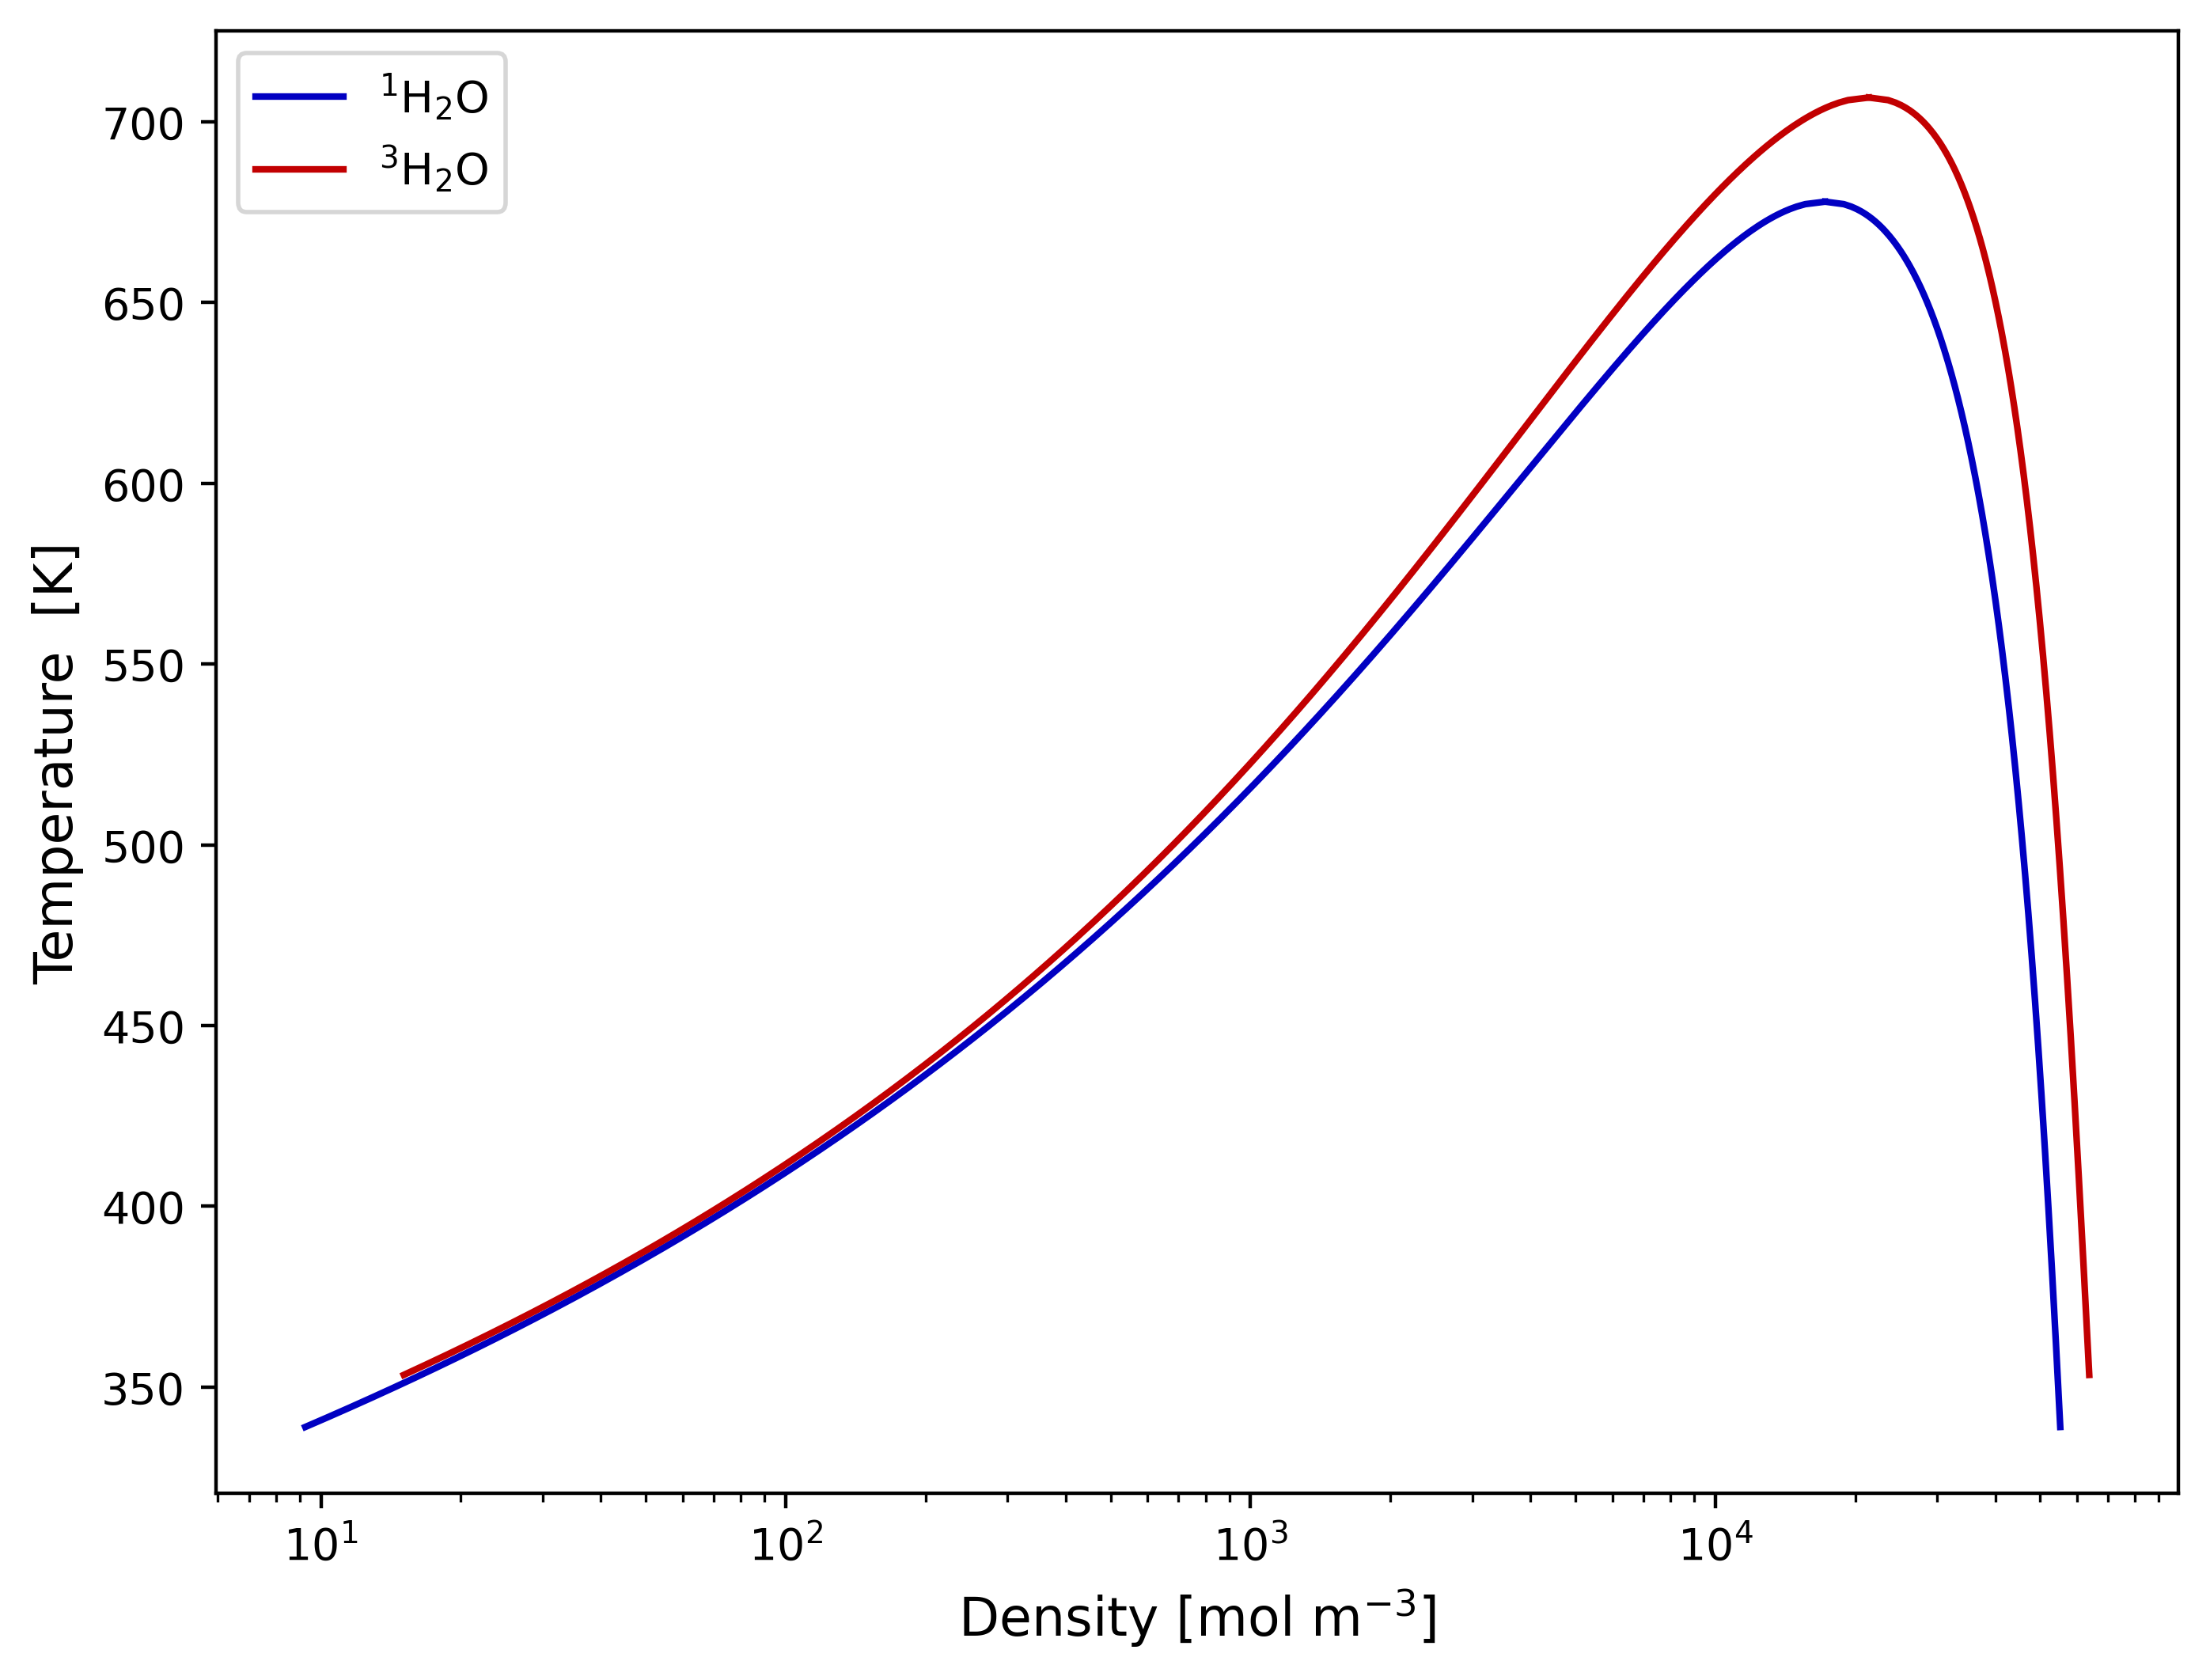

In [10]:
filtered_training_data = filter(row -> occursin("water", row.species)| occursin("tritium oxide", row.species),training_data) ;
filtered_training_data = sort(filtered_training_data, :Mw) 

nrows_data = nrow(filtered_training_data)

colour_grad_1 = collect(range(1,194,nrows_data) ./255) 
colour_grad_2 = collect(range(194,1,nrows_data) ./255)

plt.figure(figsize=(8, 6), dpi=400)

for i = 1:nrows_data
plt.semilogx(1 ./filtered_training_data[i,:sat_volumes_liq_m3_per_mol],filtered_training_data[i,:sat_temperatures_K], color = [colour_grad_1[i] 0 colour_grad_2[i]])
end

plt.xlabel("Density [mol m\$^{-3}\$]",fontsize=12)
plt.ylabel("Temperature  [K]",fontsize=12)
plt.legend(["\$^{1}\$H\$_{2}\$O","\$^{3}\$H\$_{2}\$O"])
# plt.ylim([0,1500])
# plt.xlim([10^-8,10^5])

for i = 1:nrows_data
    plt.semilogx(1 ./filtered_training_data[i,:sat_volumes_vap_m3_per_mol],filtered_training_data[i,:sat_temperatures_K],color = [colour_grad_1[i] 0 colour_grad_2[i]])
end

# plt.savefig("all_compound_phase_envelopes.png",dpi=400)